In [1]:
import math as m
import h5py 
import numpy as np
import matplotlib.pyplot as plt

In [2]:

class Antenna:
    """ antenna with location and timeseries of Efield"""
    def __init__(self,x,y,z,name=""):
        self.x = x
        self.y = y
        self.z = z
        self.name = name

class REvent:
    """ An interface class for reading simulations """
    def __init__(self,filename):
        self.reasfile = filename
        if '.reas' in filename:
            self.reasfile = filename
            self.parse_reas()
        elif '.hdf5' in filename:
            self.hdf5file = filename
            self.parse_hdf5()

    def parse_reas(self):
        """ parse *reas file """
        f = open(self.reasfile)
        lines = f.readlines()
        for l in lines:
            if 'ShowerZenithAngle' in l:
                self.zenith = float(l.split()[2])
            if 'ShowerAzimuthAngle' in l:
                self.azimuth = float(l.split()[2]) + 180
                if self.azimuth > 360:
                    self.azimuth = self.azimuth - 360
            if 'DepthOfShowerMaximum' in l:
                self.Xmax = float(l.split()[2])
            if 'PrimaryParticleEnergy' in l:
                self.energy = float(l.split()[2])
            if 'PrimaryParticleType' in l:
                self.part_id = int(l.split()[2])
            if 'MagneticFieldInclinationAngle' in l:
                self.Binc = float(l.split()[2])
            if 'MagneticFieldStrength' in l:
                self.Bmag = float(l.split()[2])
        self.parse_reas_antenas()

    def parse_reas_antenas(self):
        """Parse the antennas by reas """
        self.listfile = self.reasfile.replace('.reas','.list')
        f = open(self.listfile)
        lines = f.readlines()
        self.antennas = []
        for l in lines:
            a = Antenna(float(l.split()[2]),float(l.split()[3]),float(l.split()[4]),l.split()[5])
            efile = self.listfile.replace('.list','_coreas/raw_'+ a.name + '.dat')
            a.t, a.Ex, a.Ey, a.Ez = np.loadtxt(efile,unpack=True)
            self.antennas.append(a)

    def parse_hdf5(self):
        f = h5py.File(self.hdf5file, "r")
        self.antennas = []
        ai = f[list(f.keys())[-1] + '/AntennaInfo']
        for ai_ in ai:
            a = Antenna(ai_[1],ai_[2],ai_[3],ai_[0].decode('UTF-8'))
            self.antennas.append(a)
        print('read ' +  str(len(self.antennas)) + ' antennas')

        traces = f[list(f.keys())[-1] + '/AntennaTraces']
        for tr in traces:
            for a in self.antennas:
                if a.name == tr:
                    break
            a.t = []
            a.Ex = []
            a.Ey = []
            a.Ez =[]
            for tup in traces[tr + '/efield']:
                a.t.append(tup[0])
                a.Ex.append(tup[1])
                a.Ey.append(tup[2])
                a.Ez.append(tup[3])

        ei = f[list(f.keys())[-1] + '/EventInfo']
        ei=ei[0]
        self.zenith = 180.-ei[4]
        self.azimuth = ei[5]
        self.xmax = ei[9]
        self.energy = ei[3]
        self.part_id = ei[2].decode('UTF-8')
        self.Bmag = ei[16]
        self.Binc = ei[17]
        self.Bdec = ei[18]
        self.ground=ei[11]
        self.dist_xmax=ei[6]



read 176 antennas


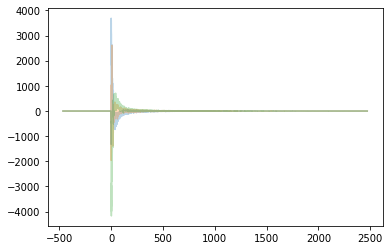

In [3]:
######################################################
file='Stshp_Proton_3.98_38.2_180.0_3.hdf5'

ev = REvent(file)

plt.plot(ev.antennas[0].t,ev.antennas[0].Ex,alpha=0.3)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ey,alpha=0.3)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ez,alpha=0.3)



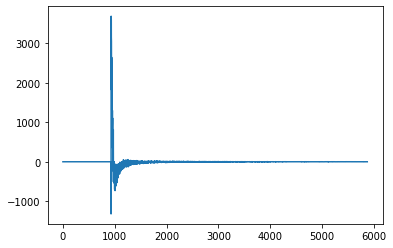

In [4]:
plt.plot(ev.antennas[0].Ex)

In [15]:
from scipy import stats
time=np.array(ev.antennas[0].t)
diff=[]
i=1
while i < int(len(time)+1):
    diff2=time[i+1]-time[i]
    np.append(diff,diff2)
    if i == int(len(time)-2):
        break
    i += 1 
print(stats.mode(diff2)) #calculating the average time between time intervals in  nano seconds

ModeResult(mode=array([0.5], dtype=float32), count=array([1]))


initialilizing a bandpass filter and checking if this commit holds)

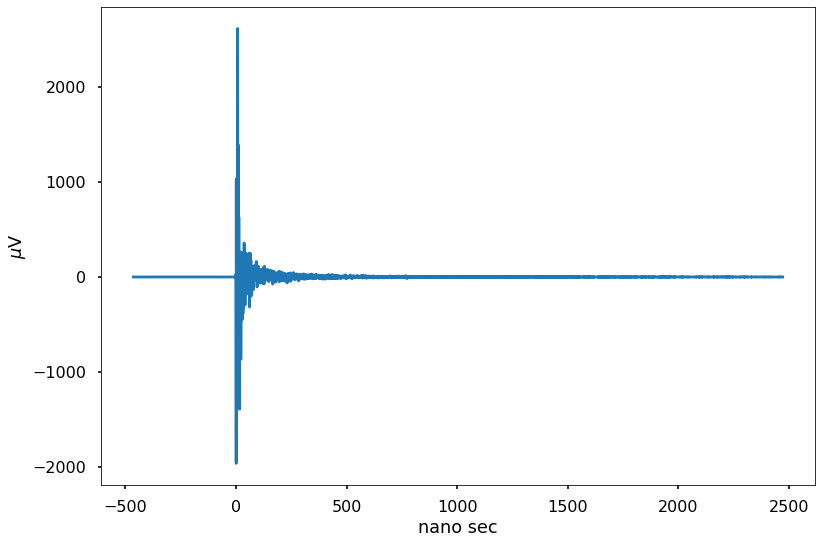

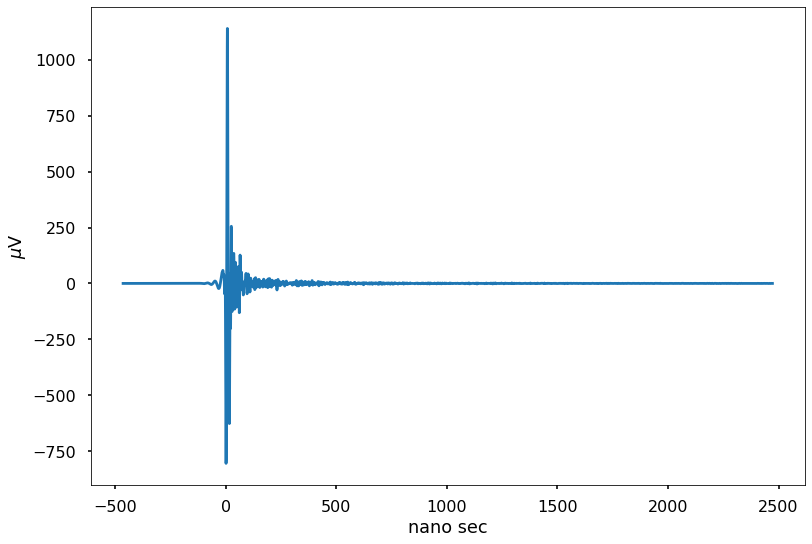

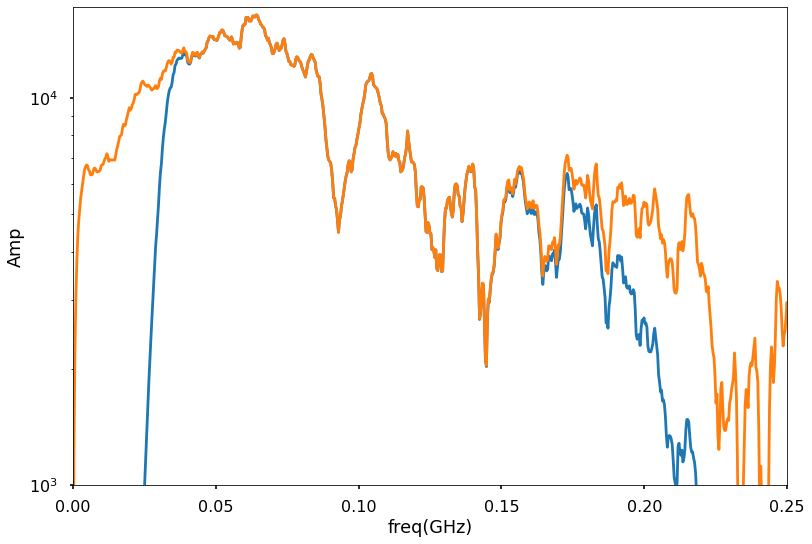

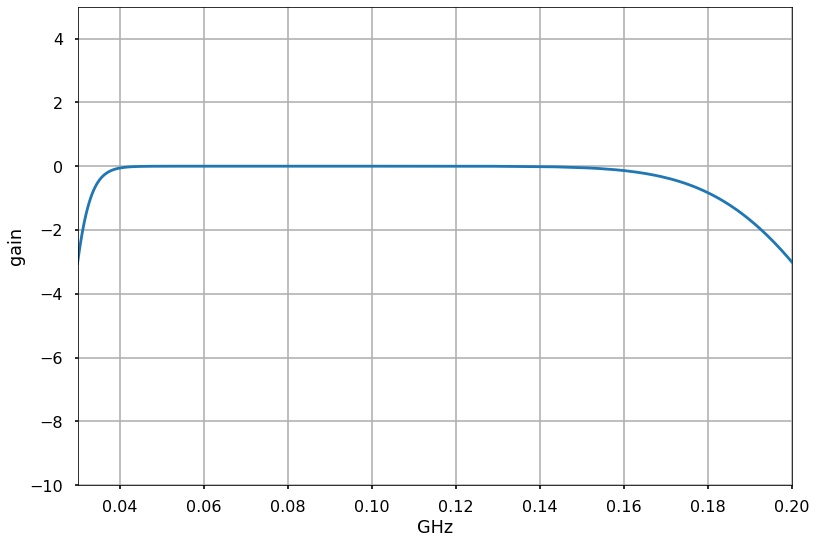

In [22]:
from scipy import signal
from scipy.signal import filtfilt
from scipy.fftpack import fft, ifft, fftfreq
import scipy



def plot():
    plt.style.use('seaborn-poster')
    data=ev.antennas[0].Ey
    ev_data=np.array(data)
    time=ev.antennas[0].t
    dt= time[1]-time[0]
    plt.plot(time,ev_data)
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    plt.show()
    
    filtered_signal=bandPassFilter(ev_data,1/dt)
    plt.plot(time,filtered_signal)
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    #plt.xlim(-50,750)
    plt.show()
    freq=np.linspace(0,1/dt,len(data))
    plt.plot(freq,abs(fft(filtered_signal)))
    plt.plot(freq,abs(fft(data)))
    plt.xlabel('freq(GHz)')  
    plt.ylabel('Amp') 
    plt.ylim(1000,)
    plt.yscale('log')
    plt.xlim(0,0.25)
    plt.show()
    plt.plot(freq,10*np.log10(abs(fft(filtered_signal))/abs(fft(data))))
    plt.xlabel('GHz')  
    plt.ylabel('gain') 
    plt.ylim(-10,5)
    plt.xlim(.03,0.2)
    plt.grid()
    plt.show()

    
def bandPassFilter(signal,fs,lowcut=0.03, hicut=0.20, order = 5):#GHz
    niq=fs/2
    low= lowcut/niq
    high=hicut/niq
   
    b,a=scipy.signal.butter(order,[low,high],'bandpass',analog=False)
    y = scipy.signal.filtfilt(b,a,signal)
    
    return (y)




plot()

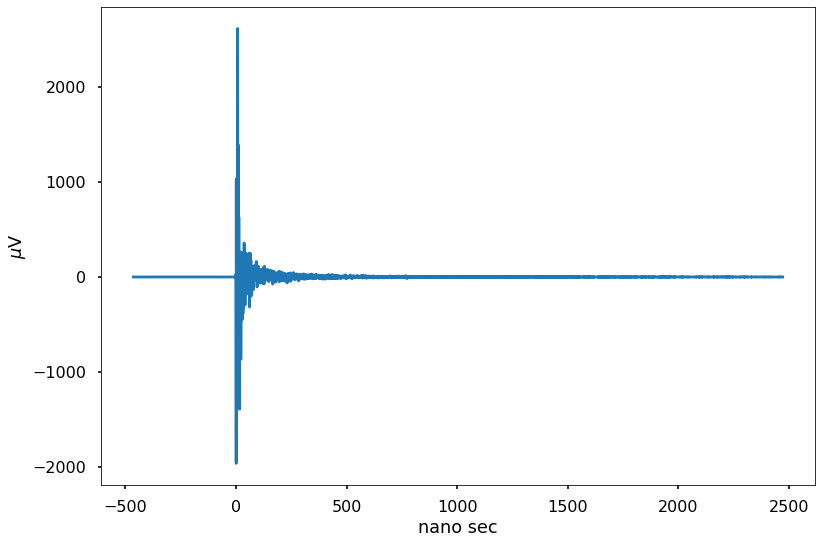

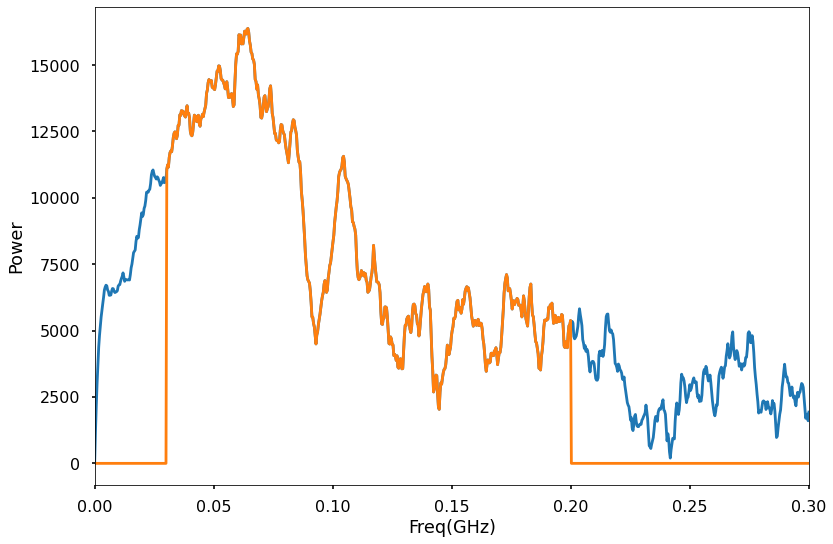

/snap/root-framework/412/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


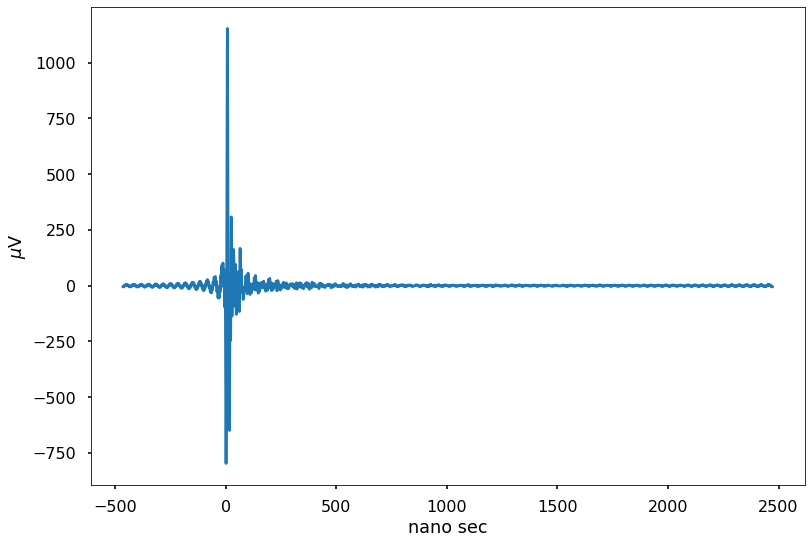

In [19]:

def band():
    plt.style.use('seaborn-poster')
    data=np.array(ev.antennas[0].Ey)
    N=data.size
    time=ev.antennas[0].t
    dt= time[1]-time[0]# interval between steps
    yf=fft(data)
    xf =fftfreq(N, dt)#[:round(N/2+1)]
    freq=np.linspace(0,1/dt,N)
    y_rel_plot=squarband(xf,yf)
    y_recon=np.fft.ifft(y_rel_plot)
    plt.plot(time,data,'-')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    plt.show()
    plt.plot(freq,abs(yf))
    plt.ylabel('Power')  
    plt.xlabel('Freq(GHz)')
    #plt.show()
    plt.plot(freq,abs(y_rel_plot),'-')
    plt.ylabel('Power')  
    plt.xlabel('Freq(GHz)') 
    plt.xlim(0,0.3)
    plt.show()
    
    plt.plot(time,y_recon,'-')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    
    
def squarband(xf,yf, low=0.03, high=0.2):
    y_rel_plot=[]
    for index in range(len(xf)):
        if low<abs(xf[index])<high:
            y_rel_plot=np.append(y_rel_plot,yf[index])      
        else:
            y_rel_plot=np.append(y_rel_plot,0)
    index+=1

    
    return (y_rel_plot)




    
band()

In [8]:
#filter comparison 

/snap/root-framework/412/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


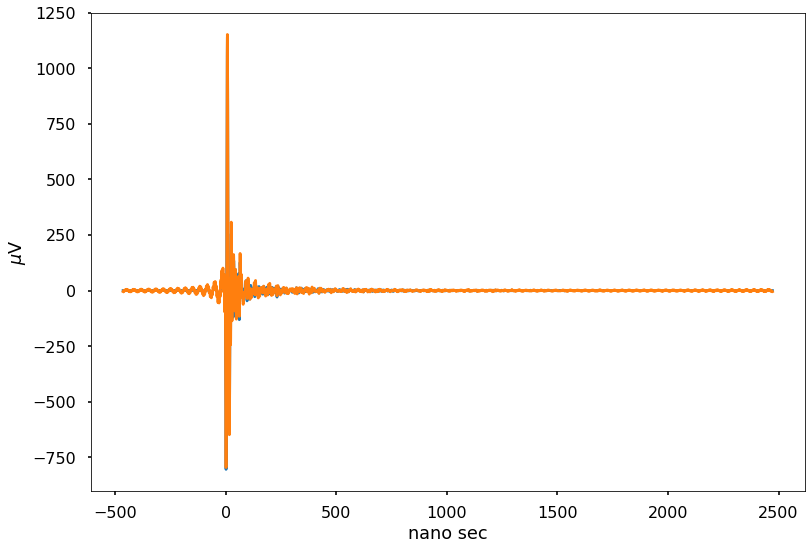

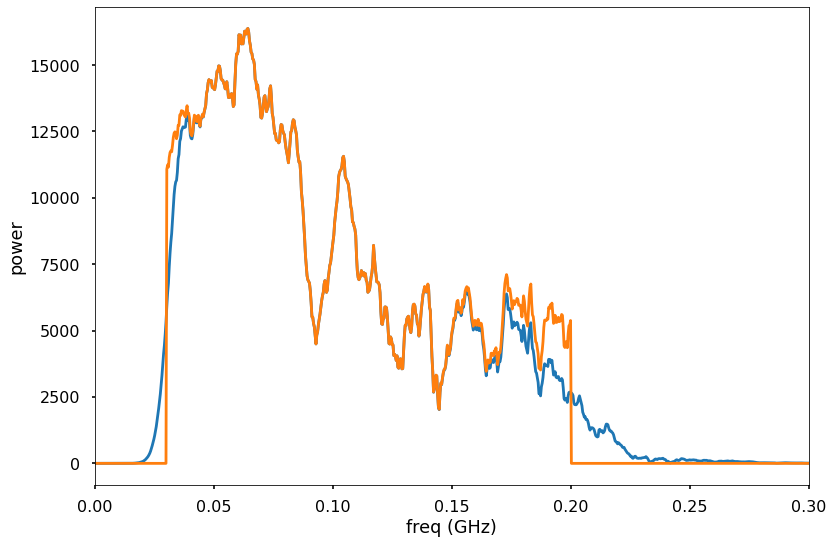

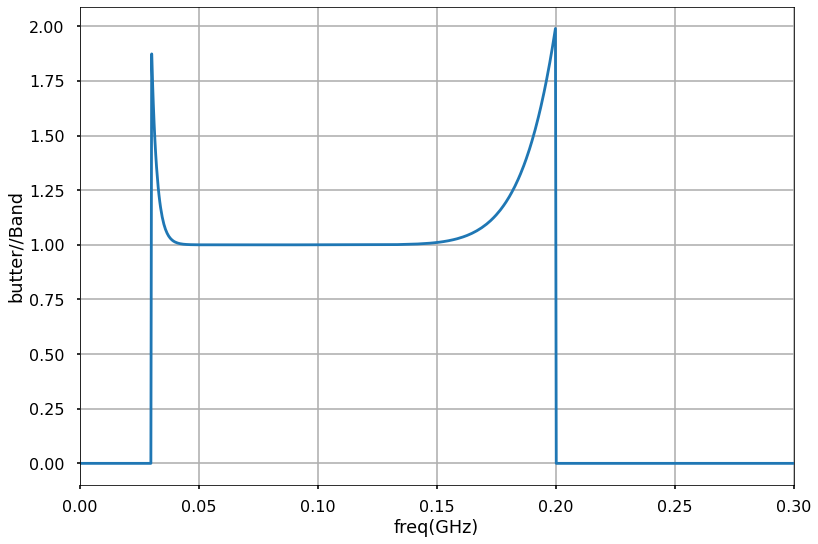

In [9]:
ev_data=np.array(ev.antennas[0].Ey)
time=ev.antennas[0].t
dt= time[1]-time[0]
yf=fft(ev_data)
xf =fftfreq(ev_data.size, dt)
filtered_signal=bandPassFilter(ev_data,1/dt)
y=bandPassFilter(ev_data,1/dt)
y_rel_plot=squarband(xf,yf)
y_recon=ifft(y_rel_plot)
freq=np.linspace(0,1/dt,ev_data.size)

plt.plot(time,filtered_signal)
plt.plot(time,y_recon)
    
plt.xlabel('nano sec')  
plt.ylabel('$\mu$V') 
#plt.xlim(-50,750)
plt.show()
    
plt.plot(freq,abs(fft(filtered_signal)))
plt.plot(freq,abs(y_rel_plot))
plt.xlim(0,0.3)
plt.xlabel("freq (GHz)")
plt.ylabel("power")
plt.show()
    
plt.plot(freq,abs(y_rel_plot)/abs(fft(filtered_signal)))
plt.xlabel('freq(GHz)')  
plt.ylabel('butter//Band') 
plt.grid()
plt.xlim(0,0.3)
plt.show()

